<a href="https://colab.research.google.com/github/sapna-90/Project---7/blob/main/P7_NLP_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
import pickle

In [2]:
Data = pd.read_csv(r"/content/twitter_disaster - P7.csv")

In [3]:
Data.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [5]:
Data.isnull().sum().sort_values(ascending=False)

,0
location,2533
keyword,61
id,0
text,0
target,0


In [6]:
numerical_cols = Data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = Data.select_dtypes(include=['object']).columns

In [7]:
# For numerical columns, we'll use the median
# For categorical columns, we'll use the most frequent value
from sklearn.impute import SimpleImputer
numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [8]:
Data[numerical_cols] = numerical_imputer.fit_transform(Data[numerical_cols])
if len(categorical_cols) > 0:
           Data[categorical_cols] = categorical_imputer.fit_transform(Data[categorical_cols])

In [9]:
Data.isnull().sum().sort_values(ascending=False)

,0
id,0
keyword,0
location,0
text,0
target,0


<ipython-input-10-09b900b1ba34>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=Data, x='target', palette='viridis')


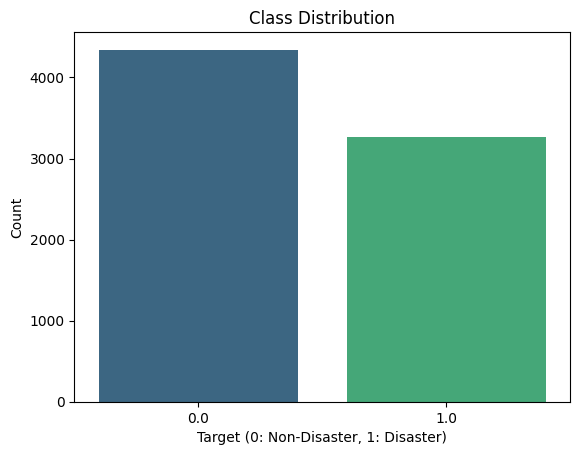

In [10]:
# Visualize class distribution
sns.countplot(data=Data, x='target', palette='viridis')
plt.title("Class Distribution")
plt.xlabel("Target (0: Non-Disaster, 1: Disaster)")
plt.ylabel("Count")
plt.show()

* The target column represents the labels: 0 for non-disaster tweets and 1 for disaster tweets.
* A bar plot of the class distribution helps confirm if the dataset is imbalanced, as this can influence model performance.

In [11]:
# Most common words in disaster and non-disaster tweets
from collections import Counter

In [12]:
def get_top_words(texts, n=10):
    all_words = ' '.join(texts).lower().split()
    return Counter(all_words).most_common(n)

In [13]:
# Top words in disaster tweets
print("Top 10 words in disaster tweets:")
print(get_top_words(Data[Data['target'] == 1]['text']))

Top 10 words in disaster tweets:
[('the', 1330), ('in', 1144), ('of', 919), ('a', 897), ('to', 753), ('and', 494), ('on', 410), ('for', 394), ('-', 389), ('is', 344)]


In [14]:
# Top words in non-disaster tweets
print("Top 10 words in non-disaster tweets:")
print(get_top_words(Data[Data['target'] == 0]['text']))

Top 10 words in non-disaster tweets:
[('the', 1877), ('a', 1238), ('to', 1181), ('i', 1052), ('and', 911), ('of', 895), ('in', 805), ('you', 625), ('is', 586), ('my', 541)]


In [15]:
# Function to clean text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Remove mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text)  # Remove hashtags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

In [16]:
# Apply cleaning
Data['cleaned_text'] = Data['text'].apply(clean_text)

The word frequency analysis helps identify commonly used terms in disaster vs. non-disaster tweets.
Text cleaning removes noise like URLs and special characters for improving model performance.

In [17]:
# Add a column for tweet length
Data['tweet_length'] = Data['cleaned_text'].apply(len)

In [18]:
Data.head()

,id,keyword,location,text,target,cleaned_text,tweet_length
0,1.0,fatalities,USA,Our Deeds are the Reason of this #earthquake M...,1.0,our deeds are the reason of this may allah fo...,58
1,4.0,fatalities,USA,Forest fire near La Ronge Sask. Canada,1.0,forest fire near la ronge sask canada,37
2,5.0,fatalities,USA,All residents asked to 'shelter in place' are ...,1.0,all residents asked to shelter in place are be...,130
3,6.0,fatalities,USA,"13,000 people receive #wildfires evacuation or...",1.0,13000 people receive evacuation orders in cal...,54
4,7.0,fatalities,USA,Just got sent this photo from Ruby #Alaska as ...,1.0,just got sent this photo from ruby as smoke f...,71


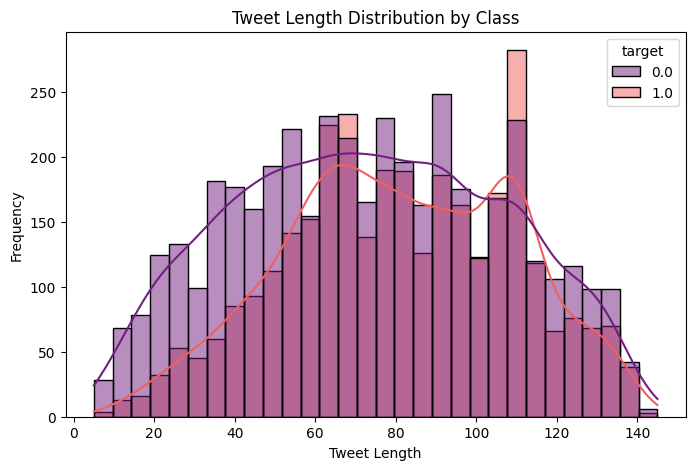

In [19]:
# Plot distribution of tweet length
plt.figure(figsize=(8, 5))
sns.histplot(data=Data, x='tweet_length', hue='target', bins=30, kde=True, palette='magma')
plt.title("Tweet Length Distribution by Class")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()

Disaster tweets tend to be shorter or more direct compared to non-disaster tweets, which may contain additional narrative or context.

In [20]:
# Split data into train and test sets
X = Data['cleaned_text']
y = Data['target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Convert text data into TF-IDF features
TFIDF = TfidfVectorizer(max_features=5000)
X_train_TFIDF = TFIDF.fit_transform(X_train)
X_test_TFIDF = TFIDF.transform(X_test)

In [23]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_TFIDF, y_train)

LogisticRegression()

In [24]:
# Predict on the test data
y_pred = model.predict(X_test_TFIDF)
y_pred_prob = model.predict_proba(X_test_TFIDF)[:, 1]

In [25]:
# Accuracy and classification report
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.799080761654629
Classification Report:
               precision    recall  f1-score   support

         0.0       0.79      0.88      0.83       874
         1.0       0.81      0.69      0.74       649

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.80      1523



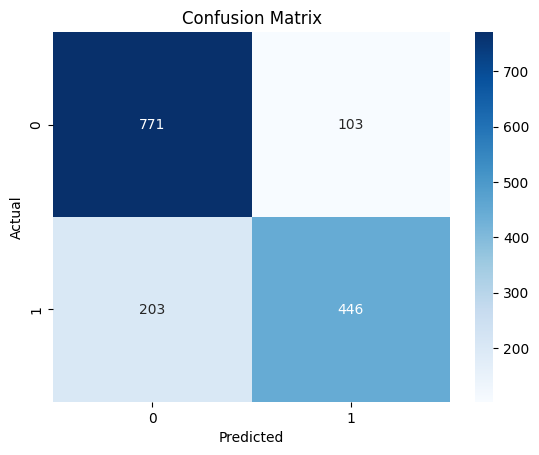

In [26]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion Matrix shows the counts of true positives, true negatives, false positives, and false negatives. A balanced model minimizes false negatives (missed disaster tweets).

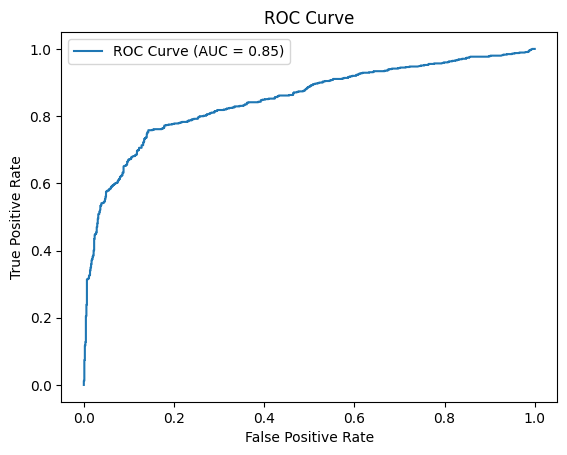

In [27]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_pred_prob)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

ROC Curve Plots the trade-off between sensitivity and specificity, helping assess overall model performance. The AUC score measures how well the model distinguishes between the two classes.

In [28]:
import pickle

# Load the model and TF-IDF vectorizer
with open("model.pkl", "wb") as file:
    pickle.dump(model, file)

with open("tfidf.pkl", "wb") as file:
    pickle.dump(TFIDF, file)